# Analysing Spectrum

In [1]:
from tardis.visualization import plot_util as pu
from astropy import units as u

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

Every simulation run requires [atomic data](io/configuration/components/atomic/atomic_data.rst) and a [configuration file](io/configuration/index.rst). 

## Atomic Data

We recommend using the [kurucz_cd23_chianti_H_He.h5](https://github.com/tardis-sn/tardis-regression-data/raw/main/atom_data/kurucz_cd23_chianti_H_He.h5) dataset.

In [2]:
from tardis.io.atom_data import download_atom_data

# We download the atomic data needed to run the simulation
download_atom_data("kurucz_cd23_chianti_H_He")

Atomic Data kurucz_cd23_chianti_H_He already exists in /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5. Will not download - override with force_download=True.


You can also obtain a copy of the atomic data from the [tardis-regression-data](https://github.com/tardis-sn/tardis-regression-data/tree/main/atom_data) repository.


## Example Configuration File

The configuration file [tardis_example.yml](https://github.com/tardis-sn/tardis/tree/master/docs/tardis_example.yml) is used throughout this Quickstart.


In [3]:
!wget -q -nc https://raw.githubusercontent.com/tardis-sn/tardis/master/docs/tardis_example.yml

In [4]:
!cat tardis_example.yml

# Example YAML configuration for TARDIS
tardis_config_version: v1.0

supernova:
  luminosity_requested: 9.44 log_lsun
  time_explosion: 13 day

atom_data: kurucz_cd23_chianti_H_He.h5

model:
  structure:
    type: specific
    velocity:
      start: 1.1e4 km/s
      stop: 20000 km/s
      num: 20
    density:
      type: branch85_w7

  abundances:
    type: uniform
    O: 0.19
    Mg: 0.03
    Si: 0.52
    S: 0.19
    Ar: 0.04
    Ca: 0.03

plasma:
  disable_electron_scattering: no
  ionization: lte
  excitation: lte
  radiative_rates_type: dilute-blackbody
  line_interaction_type: macroatom

montecarlo:
  seed: 23111963
  no_of_packets: 4.0e+4
  iterations: 20
  nthreads: 1

  last_no_of_packets: 1.e+5
  no_of_virtual_packets: 10

  convergence_strategy:
    type: damped
    damping_constant: 1.0
    threshold: 0.05
    fraction: 0.8
    hold_iterations: 3
    t_inner:
      damping_constant: 0.5

spectrum:
  start: 500 angstrom
  stop: 20000 angstrom
  num: 10000


## Running the Simulation

To run the simulation, import the `run_tardis` function and create the `sim` object.

<div class="alert alert-info">

**Note:**

Get more information about the [progress bars](io/output/progress_bars.rst), [logging configuration](io/optional/tutorial_logging_configuration.ipynb), and [convergence plots](io/visualization/tutorial_convergence_plot.ipynb).

</div>


In [5]:
from tardis import run_tardis

sim = run_tardis(
    "tardis_example.yml",
    log_level="ERROR"
)

Tabs(height=350, sizing_mode='stretch_width')
    [0] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [1] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [2] HTML(str, height=300, styles={'overflow-y': 'auto', ...})
    [3] HTML(str, height=300, styles={'overflow-y': 'auto', ...})

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

## HDF


TARDIS can save simulation data to HDF files for later analysis. The code below shows how to load a simulation from an HDF file. This is useful when you want to analyze simulation results without re-running the simulation.


In [6]:
# import astropy.units as u
# import pandas as pd

# hdf_fpath = "add_file_path_here"
# with pd.HDFStore(hdf_fpath, "r") as hdf:
#     sim = u.Quantity(hdf["/simulation"])

## Calculate integrated spectrum

<div class="alert alert-info">

**Note:**

It takes about a minute to calculate. Please be patient while it runs.

</div>

In [7]:
spectrum_integrated = sim.spectrum_solver.spectrum_integrated

[py.warnings         ][WARNING]  /home/runner/work/tardis/tardis/tardis/spectrum/formal_integral.py:398: UserWarning:

The number of interpolate_shells was not specified. The value was set to 80.

 (warnings.py:110)


## Plotting the Spectrum

Now we will plot the spectrum using matplotlib and plotly. The plots show the luminosity density as a function of wavelength.

- $\textbf{Wavelength } [\overset{\circ}{A}]$: The x-axis represents the wavelength in Angstroms.
- $\textbf{Luminosity density} [erg\;s^{-1}\;\overset{\circ}{A^{-1}}]$: The y-axis represents the luminosity density in erg per second per Angstrom.

### Matplotlib

We use Matplotlib to create a static plot of the ***formal integral spectrum*** that was calculated in the previous step.

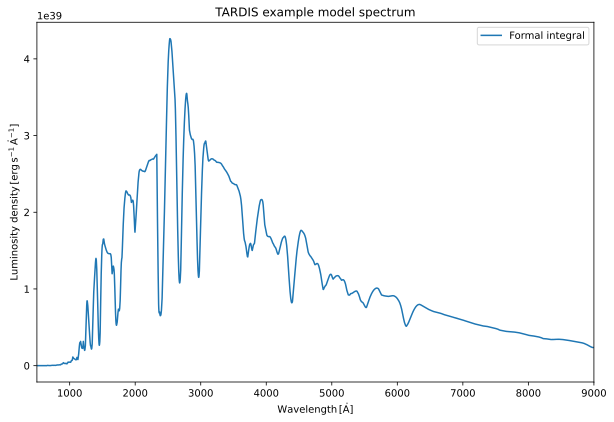

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a new figure with specified dimensions
plt.figure(figsize=(10, 6.5))

spectrum_integrated.plot(label="Formal integral")  # Plot spectrum from formal integral solution

xlabel = pu.axis_label_in_latex("Wavelength", u.AA)
ylabel = pu.axis_label_in_latex(
    "Luminosity density", u.Unit("erg/(s AA)"), only_text=True
)
# Set title, labels, and template
plt.xlim(500, 9000)
plt.title("TARDIS example model spectrum")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.show()


### Plotly


Here, we use Plotly to create an interactive plot of the ***virtual packet spectrum*** generated by the TARDIS simulation.


In [9]:
import plotly.graph_objects as go

# Create a new figure for plotting the spectrum
fig = go.Figure()

# Plot the wavelength spectrum
fig.add_trace(
    go.Scatter(
        x=sim.spectrum_solver.spectrum_virtual_packets.wavelength,
        y=sim.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
        mode="lines",
        name="Spectrum"
    )
)

xlabel = pu.axis_label_in_latex("Wavelength", u.AA)
ylabel = pu.axis_label_in_latex(
    "Luminosity density", u.Unit("erg/(s AA)"), only_text=True
)
# Set title, labels, and template
fig.update_layout(
    title="TARDIS example model spectrum",
    xaxis_title=xlabel,
    yaxis_title=ylabel,
    xaxis_range=[500, 9000],
    showlegend=True,
    template="plotly_white"
)

# Display the plot
fig.show()